In [20]:
import sys
import os
file_path = os.getcwd()
project_root =os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(file_path))))


# Libraries
import argparse
import numpy as np
import scipy.io
import time
import gc
import pandas as pd
from scipy.stats import norm


#Plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import numpy as np
import jax
from jax import jit, grad, vmap, value_and_grad,jvp

import jax.numpy as jnp
import optax
import jaxopt

from typing import Tuple
import time


import h5py
from typing import List, Dict
from pyDOE import lhs
import tqdm
import scipy.integrate as integrate
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter


In [21]:
cmap = 'rainbow'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


# Tunning Parameters

In [22]:
parser = argparse.ArgumentParser(description='Tunning_parameters')
parser.add_argument('--Run_type'   , type=str  , default='KAN_Benchmark')
parser.add_argument('--Mode'       , type=str  , default='PINN')
parser.add_argument('--Eqn'   , type=str  , default='HM')

parser.add_argument('--use_RBA'    , type=int , default=1)
parser.add_argument('--Mod_MLP'    , type=int , default=0)
parser.add_argument('--Adaptive_AF'    , type=int , default=0)
parser.add_argument('--Weight_Norm'    , type=int , default=0)
parser.add_argument('--resample' , type=int  , default=0)
parser.add_argument('--L2_reg'    , type=int , default=0)
parser.add_argument('--beta_L2' , type=float  , default=0.001)

#Resnet_params
parser.add_argument('--Use_ResNet'    , type=int , default=0)
parser.add_argument('--Adaptive'    , type=int , default=0)
parser.add_argument('--Light'    , type=int , default=0)

#KAN Params
parser.add_argument('--Network'    , type=str , default='KAN')
parser.add_argument('--degree'    , type=int , default=5)

parser.add_argument('--lr_lambdas_0' , type=float  , default=0.001)
parser.add_argument('--gamma' , type=float  , default=0.999)
parser.add_argument('--k_samp' , type=float  , default=0.75)
parser.add_argument('--c_samp' , type=float  , default=0.75)

parser.add_argument('--batch_size' , type=int  , default=500)
parser.add_argument('--g_steps' , type=int  , default=100000)
parser.add_argument('--num_layer' , type=int  , default=4)
parser.add_argument('--width_layer' , type=int  , default=32)

args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

Run_type: KAN_Benchmark
Mode: PINN
Eqn: HM
use_RBA: 1
Mod_MLP: 0
Adaptive_AF: 0
Weight_Norm: 0
resample: 0
L2_reg: 0
beta_L2: 0.001
Use_ResNet: 0
Adaptive: 0
Light: 0
Network: KAN
degree: 5
lr_lambdas_0: 0.001
gamma: 0.999
k_samp: 0.75
c_samp: 0.75
batch_size: 500
g_steps: 100000
num_layer: 4
width_layer: 32


In [23]:
Run_type =args.Run_type
Mode=args.Mode
Eqn=args.Eqn
#KANs
Network_type=args.Network
degree=args.degree
#Booleans
if args.L2_reg:
    Eqn=Eqn+f'L2:{args.beta_L2}'
use_L2_reg=args.L2_reg
use_RBA=args.use_RBA
Mod_MLP=args.Mod_MLP
Adaptive_AF=args.Adaptive_AF
Weight_Norm = args.Weight_Norm #Weight Normalization
resample=args.resample 

batch_size=args.batch_size 
num_epochs_adam =args.g_steps
beta_L2=args.beta_L2

#Resnet:
Use_ResNet=args.Use_ResNet 
Adaptive=args.Adaptive 
Light=args.Light 

if Mode.lower()[0]=='w':
    lamB =100
else:
    lamB=1
print(f'Weigth:{lamB}')

lr_lambdas_0=args.lr_lambdas_0 
gamma=args.gamma 

max_lambda=lr_lambdas_0/(1-gamma)
print(f'Max lambdas will be:{max_lambda}')

num_layer=args.num_layer 
width_layer = args.width_layer  # neurons/layer
Save_name=Network_type+':'+str(degree)
print(f'Save name:{Save_name}')
stiff=0
use_Noise=False
Dynamic_noise=False
noise_level=0


seed_np=2222
#Helmhotz
a1 = 1.0
a2 = 4.0
ksq = 1.0
lam_min=0.0


layers = [2] + num_layer*[width_layer] + [1]
layers_ref=layers.copy()
print('Model Architecture:')
print(layers)
activation = 'tanh'
initialization = 'xavier'
normalization  = 'identity'
loss_metric ='L2'
init_zero   = True
normalize_outputs=False

lh_sampling=False

T_e=num_epochs_adam

lamD =1
lamE =1
n_batches = 100
#learning 
lr0=5*10**(-4)
lrf=5*10**(-5)


decay_rate=0.9
decay_step=0
#Training details
N_points=100
N0 = 50
N_b = 50
nxb, nyb = (100,100)
N_f = nxb*nyb

#Fourier 
N=5
M=5

#SNR
measure_point_wise=200

plot_results=False

#Paths
dataset_name = Save_name

#Paths
save_path=project_root+f'/Results/{Run_type}/'
big_data_path=save_path
grads_file=f'Fig3:{Save_name}-_SNR.txt'
print(dataset_name)


Weigth:1
Max lambdas will be:0.9999999999999991
Save name:KAN:5
Model Architecture:
[2, 32, 32, 32, 32, 1]
KAN:5


In [24]:
print(f"Network:{Network_type}")
use_RBA=int(use_RBA)
print(f"Use RBA?:{use_RBA}")
use_Noise=int(use_Noise)
print(f"Use Noise?:{use_Noise}")
Dynamic_noise=int(Dynamic_noise)
print(f"Use Dynamic Noise?:{Dynamic_noise}")

Network:KAN
Use RBA?:1
Use Noise?:0
Use Dynamic Noise?:0


## Auxiliary Functions

In [25]:
def identity(X,X_min,X_max):
    return X

def MSE(pred,exact,weight=1):
    return jnp.mean(weight*jnp.square(pred - exact))

def glorot_normal(in_dim: int, out_dim: int) -> jnp.ndarray:
    glorot_stddev = np.sqrt(2.0 / (in_dim + out_dim))
    return jnp.array(np.random.normal(loc=0.0, scale=glorot_stddev, size=(in_dim, out_dim)))


def init_params(layers: List[int], initialization_type: str = 'xavier',Network_type: str='mlp',degree: int =5,Use_ResNet: bool =False) -> dict: 
    def init_adaptive_params():
        F = 0.1 * jnp.ones(3 * len(layers) - 1)
        A = 0.1 * jnp.ones(3 * len(layers) - 1)
        return [{"a0": A[3*i], "a1": A[3*i + 1], "a2": A[3*i + 2],
                 "f0": F[3*i], "f1": F[3*i + 1], "f2": F[3*i + 2]} 
                for i in range(len(layers) - 1)]
    #Define Models:
    def init_layer_mlp(in_dim, out_dim):
        if initialization_type == 'xavier':
            W = glorot_normal(in_dim, out_dim)
        elif initialization_type == 'normal':
            W = jnp.array(np.random.normal(size=(in_dim, out_dim)))
        b = jnp.zeros(out_dim)
        g = jnp.ones(out_dim)
        return {"W": W, "b": b, "g": g}

    def init_layer_kan(in_dim, out_dim,degree=degree):
        std=1 / (in_dim * (degree + 1))
        W =jnp.array(np.random.normal(loc=0.0, scale=std, size=(in_dim, out_dim,degree+1)))
        b = jnp.zeros(out_dim)
        g = jnp.ones(out_dim)
        return {"W": W, "b": b, "g": g}

    #Select model
    if Network_type.lower()=='mlp':
        init_layer_params=init_layer_mlp
    elif Network_type.lower()[:3]=='kan':
        init_layer_params=init_layer_kan
    else:
        print(f'Error: {Network_type.lower()} is not a valid option. The available options are:mlp and kan.')
    print(f'Initializing:{Network_type} parameters.')
    params = [init_layer_params(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
    U1, b1, g1 = glorot_normal(layers[0], layers[1]), jnp.zeros(layers[1]), jnp.ones(layers[1])
    U2, b2, g2 = glorot_normal(layers[0], layers[1]), jnp.zeros(layers[1]), jnp.ones(layers[1])
    
    mMLP_params = [{"U1": U1, "b1": b1, "g1": g1, "U2": U2, "b2": b2, "g2": g2}]
    
    return {
        'params': params,
        'AdaptiveAF': init_adaptive_params(),
        'mMLP': mMLP_params
    }
def KAN_Net5(params, X_in, M1, M2, activation, norm_fn):  
    def Cheby_KAN_layer5(x,layer_params,expanded_arr=[]):
        # Read chebyshev coefficients:
        cheby_coeffs= layer_params["W"]
        inputdim=cheby_coeffs.shape[0]
        outdim=cheby_coeffs.shape[1]
        # Normalize 
        x = activation(x)
        # Reshape
        x = x.reshape((-1, inputdim, 1))
        x=jnp.stack((T0(x),
                    T1(x),
                    T2(x),
                    T3(x),
                    T4(x),
                    T5(x)),axis=2)# Discard dummy dimension
        # Compute the Chebyshev interpolation
        x = jnp.einsum("bid0,iod->bo", x, cheby_coeffs)  # shape = (batch_size, output_dim)
        # Remove extra dimension
        x=  jnp.reshape(x, (outdim,))
        return x 
    #Define params   
    params_N = params["params"]
    #Normalize inputs
    x = norm_fn(X_in, M1, M2)
    for ly in range(len(params_N)):
        layer_params=params_N[ly]
        x=Cheby_KAN_layer5(x,layer_params)
    return x
def KAN_Net_theta(params, X_in, M1, M2, degree, norm_fn):    
    def Cheby_KAN_layer(x,layer_params,expanded_arr):
        # Read chebyshev coefficients:
        cheby_coeffs= layer_params["W"]
        inputdim=cheby_coeffs.shape[0]
        outdim=cheby_coeffs.shape[1]
        # Normalize 
        x = jnp.tanh(x)
        # Reshape
        x = x.reshape((-1, inputdim, 1))
        # Apply arcos -> find angle
        x = jnp.arccos(x)
        # Exapnd (generate Matrix)
        x = x * expanded_arr
        # Apply cos
        x = jnp.cos(x)
        # Compute the Chebyshev interpolation
        x = jnp.einsum("bid,iod->bo", x, cheby_coeffs)  # shape = (batch_size, output_dim)
        # Remove extra dimension
        x=  jnp.reshape(x, (outdim,))
        return x   
    #Define params   
    params_N = params["params"]
    #Normalize inputs
    x = norm_fn(X_in, M1, M2)
    #Generate array to expand inputs
    expanded_arr= jnp.arange(0,degree+1,1)[None,:]
    for ly in range(len(params_N)):
        layer_params=params_N[ly]
        x=Cheby_KAN_layer(x,layer_params,expanded_arr)
    return x

def initialize_optimizer(lr0, decay_rate, lrf, decay_step, T_e,optimizer_type='Adam',weight_decay=1e-4):
    print('Optimizer',optimizer_type.lower())
    if optimizer_type.lower()=='adam':
        if decay_rate == 0 or lrf == lr0:
            print('No decay')
            return optax.adam(lr0), decay_step
        else:
            if decay_step == 0:
                decay_step = T_e * np.log(decay_rate) / np.log(lrf / lr0)
            print(f'The decay step will be {decay_step}')
            return optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate,)),decay_step

def create_and_return_directories(save_path, dataset_name, subdirectories):
    # Base directory
    result_path = os.path.join(save_path, dataset_name)

    # Creating subdirectories and storing their paths
    paths = {}
    for subdir in subdirectories:
        path = os.path.join(result_path, subdir+'/')
        os.makedirs(path, exist_ok=True)
        paths[subdir] = path

        # Printing the paths
        print(f"The {subdir.lower().replace('_', ' ')} path is: {path}")

    return paths
def plot3D_mat(x,y,F,f_names,window=4,font_size='10',x_label='x',y_label='y',cmap='rainbow',fig_width=6):
  X,Y= x,y
  fig,ax=plt.subplots(1,len(F),figsize=(fig_width*len(F),window))
  plt.rcParams['font.size'] = font_size
  for i in range(len(ax)):
    cp = ax[i].contourf(X,Y, F[i],50,cmap=cmap)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax[i].set_title(f_names[i])
    ax[i].set_xlabel(x_label)
    if i==0:
        ax[i].set_ylabel(y_label)
def sample_all(it, batch_size, dataset, lambdas,k=1,c=0.5):
    return np.arange(len(dataset)) 

# Chebyshev's Polynomials
def T0(x):
    return x*0+1
def T1(x):
    return x
def T2(x):
    return 2*x**2-1
def T3(x):
    return 4*x**3-3*x
def T4(x):
    return 8*x**4-8*x**2+1
def T5(x):
    return 16*x**5-20*x**3+5*x

def relative_error2(pred,exact):
    return np.linalg.norm(exact-pred,2)/np.linalg.norm(exact,2)

#SAVING PARAMETERS

def save_list(Loss,path,name='loss-'):
    filename=path+name+".npy"
    np.save(filename, np.array(Loss))

def save_params_dict(params,result_path,dataset_name,type='Test',Use_ResNet=False):
    # Assuming 'result_path' and 'dataset_name' are defined elsewhere in your code
    for key, params in params.items():
        # Construct the file name for each set of parameters
        output_path = f"{result_path}{dataset_name}-{type}_params_{key}.h5"
        
        # Extract arrays from params
        params_to_save = [extract_arrays_from_params(params,Use_ResNet)]
        # Save the parameters
        save_all_params(params_to_save, output_path)
        print(f'Params {key} have been saved!')

def load_params_dict(result_path, dataset_name, layer_dict, initialization, type='Test',Use_ResNet=False):
    loaded_params = {}
    for key in layer_dict.keys():
        # Construct the file path
        file_path = f"{result_path}{dataset_name}-{type}_params_{key}.h5"
        
        # Read parameters from the file
        raw_params = read_all_params(file_path)[0]

        # Initialize a test parameter set for getting lengths
        test_params = init_params(layer_dict[key], initialization_type=initialization.lower()) 
        params_length = len(test_params['params'])
        params_length_AF = len(test_params['AdaptiveAF'])

        # Reconstruct the parameters
        reconstructed_params = reconstruct_params(raw_params, params_length, params_length_AF,Use_ResNet)

        # Store in the dictionary
        loaded_params[key] = reconstructed_params

    return loaded_params

def extract_arrays_from_params(params_test,Use_ResNet=False):
    # Extract arrays from the 'params' dictionary
    params_arrays = []
    if Use_ResNet:
        for param_dict in params_test['params']:
            for key in ['W', 'b', 'g','W2', 'b2', 'g2','alpha']:
                if key in param_dict:
                    params_arrays.append(np.array(param_dict[key]))
    else:
        for param_dict in params_test['params']:
            for key in ['W', 'b', 'g']:
                if key in param_dict:
                    params_arrays.append(np.array(param_dict[key]))

    # Extract arrays from the 'mMLP' dictionary
    mMLP_keys = ['U1', 'U2', 'b1', 'b2', 'g1', 'g2']
    mMLP_arrays = [np.array(params_test['mMLP'][0][key]) for key in mMLP_keys if key in params_test['mMLP'][0]]

    # Extract arrays from the 'AdaptiveAF' dictionary
    AdaptiveAF_keys = ['a0', 'a1', 'a2', 'f0', 'f1', 'f2']
    AdaptiveAF_arrays = []
    for adaptive_dict in params_test['AdaptiveAF']:
        for key in AdaptiveAF_keys:
            AdaptiveAF_arrays.append(np.array(adaptive_dict[key]))

    # Combine all extracted arrays
    all_arrays = params_arrays + mMLP_arrays + AdaptiveAF_arrays
    return all_arrays

def save_all_params(All_params,all_params_path):
    with h5py.File(all_params_path, 'w') as hf:
        for i, inner_list in tqdm.tqdm(enumerate(All_params)):
            group = hf.create_group(f"list_{i}")
            for j, arr in enumerate(inner_list):
                group.create_dataset(f"array_{j}", data=arr)

# Reading All params
def read_all_params(all_params_path):
    loaded_All_params = []
    with h5py.File(all_params_path, 'r') as hf:
        for key in tqdm.tqdm(sorted(hf.keys(), key=lambda x: int(x.split('_')[1]))):  # Ensure keys are processed in order
            inner_list = []
            for sub_key in sorted(hf[key].keys(), key=lambda x: int(x.split('_')[1])):
                data = hf[key][sub_key]
                if data.shape == ():  # Check if scalar
                    inner_list.append(data[()])
                else:
                    inner_list.append(data[:])
            loaded_All_params.append(inner_list)
    return loaded_All_params

def reconstruct_params(numpy_arrays_list, params_length, params_length_AF,Use_ResNet=False):
    # For ease, I'll use a pointer instead of popping items
    pointer = 0
    # Reconstruct the 'params' dictionary
    params_dicts = []
    if Use_ResNet:
        for _ in range(params_length):
            param_dict = {}
            for key in ['W', 'b', 'g','W2', 'b2', 'g2','alpha']:
                if pointer < len(numpy_arrays_list):
                    param_dict[key] = numpy_arrays_list[pointer]
                    pointer += 1
            params_dicts.append(param_dict)
    else:
        for _ in range(params_length):
            param_dict = {}
            for key in ['W', 'b', 'g']:
                if pointer < len(numpy_arrays_list):
                    param_dict[key] = numpy_arrays_list[pointer]
                    pointer += 1
            params_dicts.append(param_dict)

    # Reconstruct the 'mMLP' dictionary
    mMLP_keys = ['U1', 'U2', 'b1', 'b2', 'g1', 'g2']
    mMLP_dict = {}
    for key in mMLP_keys:
        if pointer < len(numpy_arrays_list):
            mMLP_dict[key] = numpy_arrays_list[pointer]
            pointer += 1

    # Reconstruct the 'AdaptiveAF' dictionary
    AdaptiveAF_dicts = []
    AdaptiveAF_keys = ['a0', 'a1', 'a2', 'f0', 'f1', 'f2']
    for _ in range(params_length_AF):
        adaptive_dict = {}
        for key in AdaptiveAF_keys:
            if pointer < len(numpy_arrays_list):
                adaptive_dict[key] = numpy_arrays_list[pointer]
                pointer += 1
        AdaptiveAF_dicts.append(adaptive_dict)

    # Combine all reconstructed dictionaries
    reconstructed_params_test = {
        'AdaptiveAF': AdaptiveAF_dicts,
        'mMLP': [mMLP_dict],
        'params': params_dicts,
    }
    
    return reconstructed_params_test

# Seetings

In [26]:
# Fetching activation function
activation_fn = jnp.tanh
# Fetching normalization functions and metrics
norm_fn = identity
Norm_metric1 = lambda x: 0
Norm_metric2 = lambda x: 0

# Fetching error function
Error_fn = MSE
# %%
np.random.seed(seed_np)
params = init_params(layers,initialization_type=initialization.lower(),degree=degree,Network_type=Network_type,Use_ResNet=Use_ResNet) 
# Model selection
pinn_fn =KAN_Net5
print(f'The model will be: {pinn_fn}')

# Optimizer Initialization
optimizer_w,decay_step = initialize_optimizer(lr0, decay_rate, lrf, decay_step, T_e)
opt_state_w = optimizer_w.init(params)

# %%
M1= Norm_metric1
M2= Norm_metric2
print('Norm metrics:',M1,M2)


Initializing:KAN parameters.
The model will be: <function KAN_Net5 at 0x7fe5bad20900>
Optimizer adam
The decay step will be 4575.749056067512
Norm metrics: <function <lambda> at 0x7fe5bad20860> <function <lambda> at 0x7fe5bad21e40>


In [27]:
subdirs = ["General","Imgs", "Big_Data", "Data", "Lambdas", "Errors"]
paths = create_and_return_directories(save_path, dataset_name, subdirs)
result_path = paths["General"]
images_path = paths["Imgs"]
big_path = paths["Big_Data"]
lambdas_path = paths["Lambdas"]
errors_path = paths["Errors"]

The general path is: /oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN:5/General/
The imgs path is: /oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN:5/Imgs/
The big data path is: /oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN:5/Big_Data/
The data path is: /oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN:5/Data/
The lambdas path is: /oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN:5/Lambdas/
The errors path is: /oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN:5/Errors/


## Generate Data


In [28]:
lb = np.array([-1.0])
ub = np.array([1.0])
rb = np.array([1.0])
lftb = np.array([-1.0])
nx, ny = (1001,1001)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
xv, yv = np.meshgrid(x,y)
x = np.reshape(x, (-1,1))
y = np.reshape(y, (-1,1))

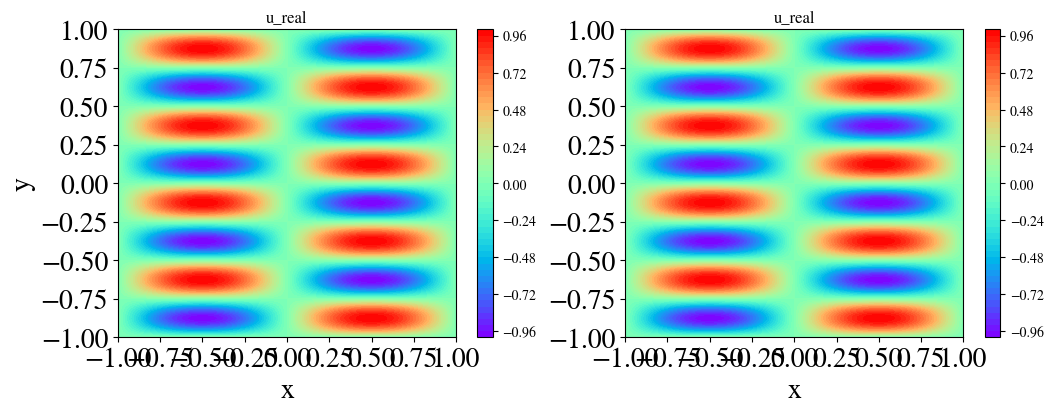

In [29]:
Exact_u = np.sin(a1*np.pi*xv)*np.sin(a2*np.pi*yv)
X,Y=np.meshgrid(x,y,indexing='ij')
u=np.reshape(Exact_u ,(nx,ny)).T
Exact=np.array([u,u]) #we store them this way only to plot them
plot3D_mat(X,Y,Exact,f_names=['u_real','u_real'],cmap=cmap)

# Training Points

In [30]:
# Boundary Conditions
xb = np.linspace(-1, 1, N_b)
yb = np.linspace(-1, 1, N_b)
Xb, Yb = np.meshgrid(xb,yb)
xb = np.reshape(xb, (-1,1))
yb = np.reshape(yb, (-1,1))
X_lb = np.hstack((Xb[0,:].flatten()[:,None],Yb[0,:].flatten()[:,None]))
X_ub = np.hstack((Xb[-1,:].flatten()[:,None],Yb[-1,:].flatten()[:,None]))
X_rb = np.hstack((Xb[:,0].flatten()[:,None],Yb[:,0].flatten()[:,None]))
X_lftb = np.hstack((Xb[:,-1].flatten()[:,None],Yb[:,-1].flatten()[:,None]))

# Residuals
xb = np.linspace(-1, 1, nxb)
yb = np.linspace(-1, 1, nyb)

Xb, Yb = np.meshgrid(xb,yb)
xb = np.reshape(xb, (-1,1))
yb = np.reshape(yb, (-1,1))
X_f=np.hstack((Xb.flatten()[:,None],Yb.flatten()[:,None]))
if lh_sampling:
    X_f=lb + (ub-lb)*lhs(2, N_f)
    print(f'Latin Hyper Cube Sampling:{lh_sampling}, shape: {X_f.shape}')
# Rename Data
X_BCs    =np.vstack((X_lb,X_ub,X_rb,X_lftb))
X_res    =np.vstack((X_f))
X_BCs_U  =X_ub
X_BCs_L  =X_lb
X_BCs_R  =X_rb
X_BCs_Lf  =X_lftb
X_exact=np.hstack((X.flatten()[:,None],
                   Y.flatten()[:,None],
                   u.flatten()[:,None]))

# Data Details

In [31]:

print(f'Bounds for BCs Data with {X_BCs_U.shape} points:')
print(np.min(X_BCs_U,axis=0))
print(np.max(X_BCs_U,axis=0))


print(f'Bounds for BCs Data with {X_BCs_L.shape} points:')
print(np.min(X_BCs_L,axis=0))
print(np.max(X_BCs_L,axis=0))

print(f'Bounds for BCs Data with {X_BCs_R.shape} points:')
print(np.min(X_BCs_R,axis=0))
print(np.max(X_BCs_R,axis=0))

print(f'Bounds for BCs Data with {X_BCs_Lf.shape} points:')
print(np.min(X_BCs_Lf,axis=0))
print(np.max(X_BCs_Lf,axis=0))

print(f'Bounds for Residual Data with {X_res.shape} points:')
print(np.min(X_res,axis=0))
print(np.max(X_res,axis=0))

# Normalization constants  (It is identity so its just zero)
M1= Norm_metric1(X_res[:, :2])
M2= Norm_metric2(X_res[:, :2])
print('Norm Metrics:',M1,M2)

Bounds for BCs Data with (50, 2) points:
[-1.  1.]
[1. 1.]
Bounds for BCs Data with (50, 2) points:
[-1. -1.]
[ 1. -1.]
Bounds for BCs Data with (50, 2) points:
[-1. -1.]
[-1.  1.]
Bounds for BCs Data with (50, 2) points:
[ 1. -1.]
[1. 1.]
Bounds for Residual Data with (10000, 2) points:
[-1. -1.]
[1. 1.]
Norm Metrics: 0 0


# Initilize Weights

In [32]:
np.random.seed(seed_np)
lambda_bcs=np.random.uniform(0,1,X_BCs_U.shape[0]*layers[-1]).reshape(X_BCs_U.shape[0],layers[-1])
#np.random.seed(seed_np)
lambda_res=np.random.uniform(0,1,X_res.shape[0]*layers[-1]).reshape(X_res.shape[0],layers[-1])
if init_zero:
    print('Setting Zero Initialization')
    lambda_bcs=lambda_bcs*0+max_lambda//5
    lambda_res=lambda_res*0+max_lambda//5
lambdas={
         'BCs':lambda_bcs,
         'Res':lambda_res}

Setting Zero Initialization


# Loss Functions

In [33]:
def u_PINN(params):
    u_NN = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn)
    u = lambda x: u_NN(x)[0]
    return u    
#Def PDE
def PDE(params):
    u_NN = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn)
    u = lambda x: u_NN(x)[0]
    # derivatives
    u_x              = lambda x: grad(u)(x)[0]
    u_y              = lambda x: grad(u)(x)[1]
    u_xx             = lambda x: grad(u_x)(x)[0]
    u_yy             = lambda x: grad(u_y)(x)[1]
    #Forcing Term
    q                = lambda x:(- (a1*jnp.pi)**2*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]) - 
                                (a2*jnp.pi)**2*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]) + 
                                    ksq*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]))
    # equations
    eq1 = (
                    lambda x:  u_xx(x) + u_yy(x) + ksq*u(x) - q(x)
    )
    
    return eq1
u_model=u_PINN
print('Choosen Model:',u_model)
print(f'Weights for BCs and Data:{lamB},{lamD}')

Choosen Model: <function u_PINN at 0x7fe5babab880>
Weights for BCs and Data:1,1


In [34]:
# For Adam Optimizer
@jit
def update(params, 
           lambdas,
           opt_state_w, 
           data: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray],
           idx_res,
           epoch):
    X_BCs_U, X_BCs_L,X_BCs_R,X_BCs_Lf, X_res  = data
    def loss_fn(params):
        X_res_subset=X_res[idx_res]
        # Call Functions
        eq1                 = PDE(params)
        u_fx                = u_model(params)
        # Residuals prediction
        e_helmholtz         = vmap(eq1, (0))(X_res_subset)[:,None]
        r_j=jnp.abs(e_helmholtz)
        #Update lambdas
        lam_res             = (gamma)*lambdas['Res'][idx_res] + lr_lambdas_0*(r_j/jnp.max(r_j))
        lambdas['Res']      = lambdas['Res'].at[idx_res].set(lam_res)
        # BCs prediction 
        tx_up          = X_BCs_U[:, :2]
        u_pred_bcs_up  = vmap(u_fx, (0))(tx_up)[:,None]
        # BCs prediction 
        tx_low        = X_BCs_L[:, :2]
        u_pred_bcs_low= vmap(u_fx, (0))(tx_low)[:,None]

        # BCs prediction 
        tx_r        = X_BCs_R[:, :2]
        u_pred_bcs_r= vmap(u_fx, (0))(tx_r)[:,None]

        # BCs prediction 
        tx_lft        = X_BCs_Lf[:, :2]
        u_pred_bcs_lft= vmap(u_fx, (0))(tx_lft)[:,None]
        #Add noise
        e_helmholtz=e_helmholtz
        # Loss Weights
        lamE_it=use_RBA*lambdas['Res'][idx_res]  +(1-use_RBA)
        lamB_it=1
        #Loss Equation
        loss_helmholtz           = lamE*Error_fn(e_helmholtz,0.0,weight=lamE_it)
        #Loss Bcs u
        loss_up                  = lamB*Error_fn(u_pred_bcs_up,0.0,weight=lamB_it)
        loss_low                 = lamB*Error_fn(u_pred_bcs_low,0.0,weight=lamB_it)
        loss_r                   = lamB*Error_fn(u_pred_bcs_r,0.0,weight=lamB_it)
        loss_lf                  = lamB*Error_fn(u_pred_bcs_lft,0.0,weight=lamB_it)
        #Total Loss
        loss                = (        
                              + loss_helmholtz
                              + loss_up
                              + loss_low
                              + loss_r
                              + loss_lf
                              )
        return loss, (
                     (loss,
                      Error_fn(e_helmholtz,0.0),
                      jnp.mean(jnp.square(u_pred_bcs_up)
                     +jnp.square(u_pred_bcs_low)
                     +jnp.square(u_pred_bcs_up)
                     +jnp.square(u_pred_bcs_up)),
                     ),
                     lambdas
        )

    grad_fn = value_and_grad(loss_fn, has_aux=True)
    #Update weights
    (_, aux_vals),all_grads=grad_fn(params)
    losses,lambdas         =aux_vals
    grad_w                 =all_grads
    updates, opt_state_w = optimizer_w.update(grad_w, opt_state_w, params)
    params  = optax.apply_updates(params, updates)

    return params, lambdas, opt_state_w, losses, grad_w

### Errors

In [35]:
def get_errors(epoch,Errors,N_its,params,X_exact):
    N_its=int(N_its/100)
    errors=np.zeros((1,3))
    eq1                 = PDE(params)
    u_fx                = u_model(params)
    # Residuals prediction
    e_helmholtz_clean         = vmap(eq1, (0))(X_res)[:,None]
    noise_level_it=noise_level*jnp.exp(stiff*epoch/num_epochs_adam)/jnp.exp(stiff)
    key=jax.random.PRNGKey(epoch)
    noise=e_helmholtz_clean*noise_level_it*jax.random.normal(key)
    e_helmholtz=e_helmholtz_clean+use_Noise*noise
    e_helmholtz         = jax.device_get(e_helmholtz)
    e_helmholtz_clean   = jax.device_get(e_helmholtz_clean)
    #prediction 
    xy, u_real          = X_exact[:, :2], X_exact[:, 2:]
    u_pred              = vmap(u_fx, (0))(xy)[:,None]
    u_pred              =jax.device_get(u_pred)
    #Compute errors
    errors[0,0]=relative_error2(u_pred,u_real)
    errors[0,1]=np.linalg.norm(u_real-u_pred,np.inf)
    errors[0,2]=Error_fn(e_helmholtz,0.0)
    Errors=np.vstack((Errors,errors))
    #Plot prediction
    xy                  = X_res[:, :2]
    u_pred              = vmap(u_fx, (0))(xy)[:,None]
    u_pred              =jax.device_get(u_pred)
    return u_pred,e_helmholtz,errors,Errors

# Training 


In [36]:
log_loss     = []
log_epoch    = []
log_SNR      = []
log_lambdas  = []
epoch_losses = []
log_grads    = []
log_u_pred   = []
log_params   = []
log_res      = []
ratio_loss   = []
log_L2=[]
log_it=[]
starting_epoch=0
Errors=np.zeros((1,3))
errors=np.zeros((1,3))
Mu=np.zeros((1,len(layers)-1))
Sigmas=np.zeros((1,len(layers)-1))
Norm=np.zeros((1,len(layers)-1))
start_time = time.time()
start_time2 = time.time()
for epoch in range(1, num_epochs_adam+1):
    idx_res=sample_all(epoch, batch_size, X_res, lambdas,k=args.k_samp,c=args.c_samp)
    batch_data =   (X_BCs_U,
                    X_BCs_L,
                    X_BCs_R,
                    X_BCs_Lf,
                    X_res)
    params, lambdas, opt_state_w, batch_losses, grad_w = update(
    params, lambdas, opt_state_w, batch_data,idx_res,epoch)
    
    if epoch%1000==0:
        log_params.append(params)
        #Get Losses
        epoch_losses.append(batch_losses)
        loss_avg: np.ndarray = np.mean(np.array(jax.device_get(epoch_losses)), axis=0)
        (
                loss,
                loss_helmholtz,
                loss_u_bcs,
        ) = loss_avg
        epoch_losses = []
        ratio_loss.append(loss_u_bcs/loss_helmholtz)
        log_lambdas.append(jax.device_get(lambdas))
        log_grads.append(jax.device_get(grad_w))
        # Learnig Rate
        optim_step =  epoch
        lr = lr0 * decay_rate ** (optim_step / decay_step)
        ##Store
        log_epoch.append(epoch)
        log_loss.append(loss_avg)
        end_time = time.time()
        #Plot Lambdas
        u_pred,e_helmholtz,errors,Errors=get_errors(epoch,Errors,num_epochs_adam,params,
                                                    X_exact)
        log_u_pred.append(u_pred)
        log_res.append(e_helmholtz)
        log_L2.append(errors[0,0])
        log_it.append(epoch)
        Error    =(
                +loss_helmholtz
                +loss_u_bcs)
        lambda_bcs_print=np.mean(lamB*lambdas['BCs'])
        lambda_res_print=np.mean(lamE*lambdas['Res'])

        print("-" * 100)
        print(Save_name)

        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Time: {end_time-start_time:.2f}s, Learning Rate: {lr:.1e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Total Error: {Error:.3e}, Total Loss: {loss:.3e}, ")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Relative L2: {errors[0,0]:.3e}, Relative Linfty: {errors[0,1]:.3e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Loss_helmholtz: {loss_helmholtz:.3e}, Loss BCs(u): {loss_u_bcs:.3e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Lambda BCs: {lambda_bcs_print:.3e}, Lambda PDE: {lambda_res_print:.3e}")

        start_time = time.time()
end_time2 = time.time()


----------------------------------------------------------------------------------------------------
KAN:5
Epoch: 1000, It: 1000, Time: 15.60s, Learning Rate: 4.9e-04
Epoch: 1000, It: 1000, Total Error: 4.240e+00, Total Loss: 7.272e-01, 
Epoch: 1000, It: 1000, Relative L2: 8.249e-02, Relative Linfty: 1.773e-01
Epoch: 1000, It: 1000, Loss_helmholtz: 4.217e+00, Loss BCs(u): 2.354e-02
Epoch: 1000, It: 1000, Lambda BCs: 0.000e+00, Lambda PDE: 1.312e-01
----------------------------------------------------------------------------------------------------
KAN:5
Epoch: 2000, It: 2000, Time: 3.93s, Learning Rate: 4.8e-04
Epoch: 2000, It: 2000, Total Error: 1.533e+00, Total Loss: 3.735e-01, 
Epoch: 2000, It: 2000, Relative L2: 7.197e-02, Relative Linfty: 1.596e-01
Epoch: 2000, It: 2000, Loss_helmholtz: 1.510e+00, Loss BCs(u): 2.256e-02
Epoch: 2000, It: 2000, Lambda BCs: 0.000e+00, Lambda PDE: 1.863e-01
-----------------------------------------------------------------------------------------------

## Save Params

In [ ]:
saved_params={
    'Hm':params
}
layers_params={
    'Hm':layers
}
# Save
save_params_dict(saved_params,result_path,dataset_name,type='Test',Use_ResNet=Use_ResNet)
# Load
loaded_params=load_params_dict(result_path, dataset_name, layers_params, initialization, type='Test',Use_ResNet=False)


0it [00:00, ?it/s]

1it [00:00, 15.36it/s]


Params Hm have been saved!


100%|██████████| 1/1 [00:00<00:00, 78.96it/s]

Initializing:mlp parameters.


## Losses and Errors

In [ ]:
save_list(log_loss,result_path,f'{Save_name}-Loss')
Errors=Errors[1:]
show=-1
losses=np.array(log_loss)
epochs=np.arange(len(losses))

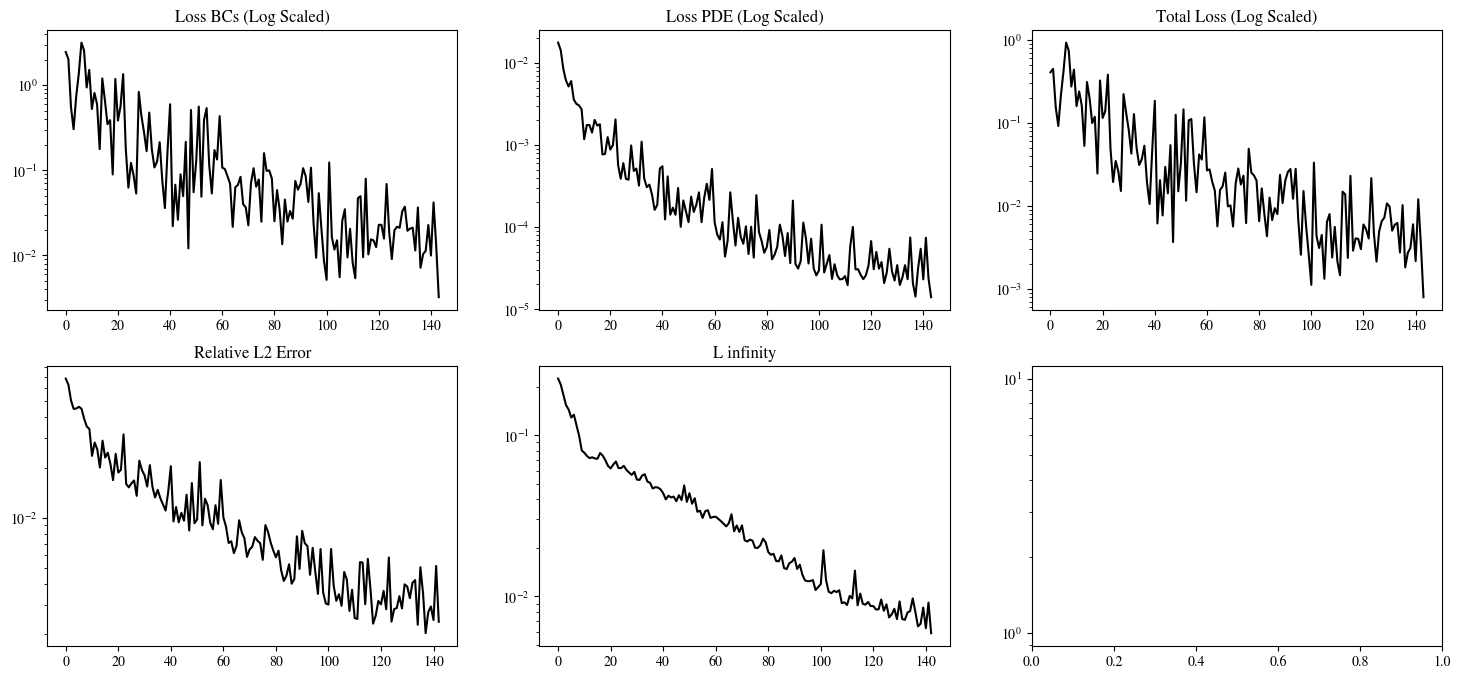

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(18,8))
axs[0, 0].plot(np.arange(len(losses[:,1])), losses[:,1],'k',label='KAN')
axs[0, 0].set_title('Loss BCs (Log Scaled)')
axs[0, 1].plot(np.arange(len(losses[:,2])), losses[:,2],'k',label='KAN')
axs[0, 1].set_title('Loss PDE (Log Scaled)')
axs[0, 2].plot(np.arange(len(losses[:,0])), losses[:,0],'k',label='KAN')
axs[0, 2].set_title('Total Loss (Log Scaled)')
axs[1, 0].plot(np.arange(len(Errors[:,0])), Errors[:,0],'k',label='KAN')
axs[1, 0].set_title('Relative L2 Error')
axs[1, 1].plot(np.arange(len(Errors[:,1])), Errors[:,1],'k',label='KAN')
axs[1, 1].set_title('L infinity')
for i in range(2):
    for j in range(3):
        axs[i,j].set_yscale('log')

plt.savefig(images_path+'/Losses-Model.png')

100%|██████████| 144/144 [00:00<00:00, 15706.96it/s]


/oscar/data/gk/jdtoscan/AIV/Instant-AIV/Results/KAN_Benchmark/KAN_theta:5/General/Fig3:KAN_theta:5-_SNR-lambdas_history.mat


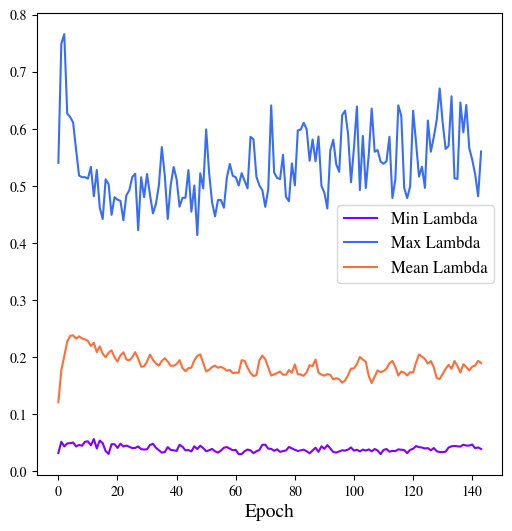

In [ ]:
lambda_res_min=[]
lambda_res_max=[]
lambda_res_mean=[]
for i in tqdm.tqdm(range(len(log_lambdas))):
    lambda_res_min.append(lamE*np.min(log_lambdas[i]['Res']))
    lambda_res_max.append(lamE*np.max(log_lambdas[i]['Res']))
    lambda_res_mean.append(lamE*np.mean(log_lambdas[i]['Res']))
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(np.arange(len(lambda_res_max)), (lambda_res_min), label = f'Min Lambda')
axs.plot(np.arange(len(lambda_res_max)), (lambda_res_max),  label = f'Max Lambda')
axs.plot(np.arange(len(lambda_res_mean)),(lambda_res_mean),  label = f'Mean Lambda')
axs.set_xlabel('Epoch',fontsize='14')
axs.legend(fontsize='12')
plt.savefig(images_path+f'/Mean-lamb:{lamB,lamD,lamE},epochs:{num_epochs_adam},lr:{lr_lambdas_0}.png')
lambda_res_min=np.array(jax.device_get(lambda_res_min))
lambda_res_max=np.array(jax.device_get(lambda_res_max))
lambda_res_mean=np.array(jax.device_get(lambda_res_mean))
name_lambdas_hist=result_path+grads_file[:-4]+'-lambdas_history.mat'
Final_lambdas={"min":lambda_res_min,
              "max":lambda_res_max,
              "mean":lambda_res_mean}
scipy.io.savemat(name_lambdas_hist, Final_lambdas)
print(name_lambdas_hist)


# Results from loaded parameters

(1002001, 1)


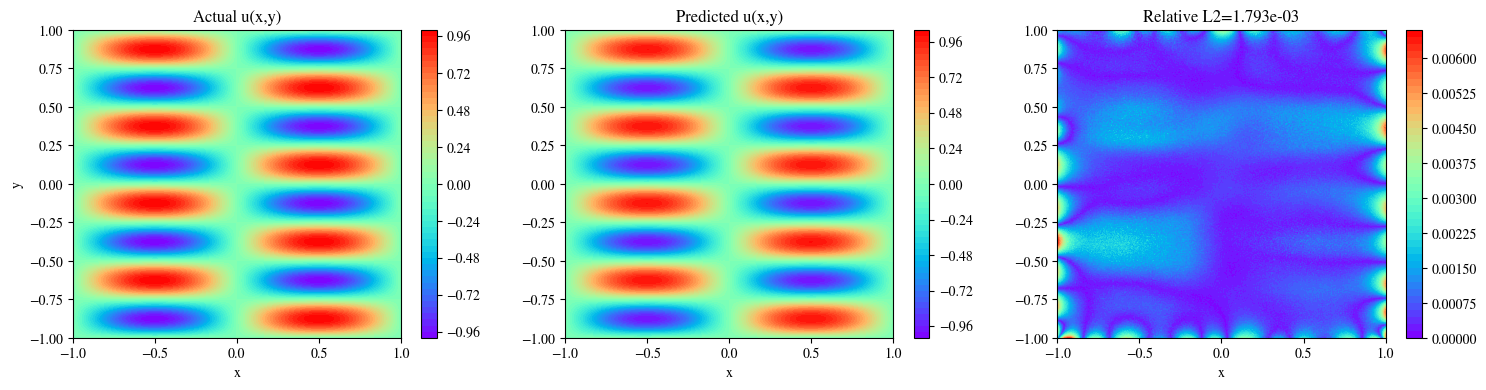

In [ ]:
u_fx                = u_model(loaded_params['Hm'])
xy, u_real          = X_exact[:, :2], X_exact[:, 2:]
u_pred              = vmap(u_fx, (0))(xy)[:,None]
print(u_pred.shape)
U_pred=np.reshape(u_pred,(nx,ny))
Error=np.abs(u-U_pred)
Exact=np.array([u,U_pred,Error])  
RL2=relative_error2(u_pred.flatten(),u_real.flatten())
plot3D_mat(X,Y,Exact,f_names=['Actual u(x,y)','Predicted u(x,y)',f'Relative L2={RL2:.3e}'],cmap='rainbow')
plt.savefig(images_path+f'/Adam.png')

# References

Shukla, K., Toscano, J. D., Wang, Z., Zou, Z., & Karniadakis, G. E. (2024). A comprehensive and fair comparison between mlp and kan representations for differential equations and operator networks. Computer Methods in Applied Mechanics and Engineering, 431, 117290.

Toscano, J. D., Käufer, T., Wang, Z., Maxey, M., Cierpka, C., & Karniadakis, G. E. (2024). Inferring turbulent velocity and temperature fields and their statistics from Lagrangian velocity measurements using physics-informed Kolmogorov-Arnold Networks. arXiv preprint arXiv:2407.15727.

Toscano, J. D., Wang, L. L., & Karniadakis, G. E. (2024). KKANs: Kurkova-Kolmogorov-Arnold Networks and Their Learning Dynamics. arXiv preprint arXiv:2412.16738.
